In [20]:
#!/usr/bin/env python
# coding: utf-8

import os, sys, re
from glob import glob

# core nltk
import nltk
from nltk.tokenize import word_tokenize

# gensim magic
import gensim
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

from sklearn.feature_extraction.text import CountVectorizer

import gzip
import gc 

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
stopWords = [",","the","and","of","or","to","in","shall","be","that","any","by",".",
              "such","as","this","for","same","all","said","other","'s",";",
              "her","is","every","[","]","they","within", "our", "not", "so",
              "made", "no", "then", ":", "do", "from", "if", "it", "which", "at", "with",
             "thereof","upon", "a", "because", "used", "some", "but", "aforesaid", "also",
             ")","(", "what", "&", "may", "are", "their", "them", "sayde", "suche", "shalbe", "anye", "sayd",
             "thesaid", "/", "...", "/", "either", "haue", "vnto", "thy", "did", "was", "were", "have", "thee", 
             "your", "thou", "unto", "hath", "had", "went", "same", "is"]

In [22]:
vectorizer = CountVectorizer(
    input='content',
    lowercase=True,
    ngram_range=(1,3),
    strip_accents=None,
    stop_words=stopWords)

In [23]:
# extra bi and trigrams that contain our terms
# return top twenty
def extract_top_ngrams(key_terms,model):
    vocab_sums = model.sum(axis=0)
    ktd = dict()
    for k in key_terms:
        ktd[k] = list()
    for i, idx in vectorizer.vocabulary_.items():
        for k in key_terms:
            if re.search("\\b{0}\\b".format(k),i) != None:
                    ktd[k].append([i,vocab_sums[0, idx]])
    
    for k in ktd.keys():
        ktd[k] = sorted(ktd[k], key = lambda x: x[1], reverse=True)[:20]
    return(ktd)

In [24]:
def plot_top_ngrams(ktd,model_name):
    
    for d in ktd.keys():
        plt.rcdefaults()
        ig, ax = plt.subplots()
        y = np.arange(len(ktd[d]))
        labels = [x[0] for x in ktd[d]]
        ax.barh(y,[x[1] for x in ktd[d]])
        ax.set_yticks(y)
        ax.set_yticklabels(labels)
        ax.invert_yaxis()
        title = d + ": " + model_name.replace("eebo-","")
        plt.title(title)
        plt.show()

In [25]:
def preprocess(raw_text):
    # tokenize
    tokens = word_tokenize(raw_text)    

    # drop to lowercase
    tokens = [word.lower() for word in tokens]
        
    # *step two* (default): remove non-alpha characters,
    # punctuation, and as many other "noise" elements as
    # possible. If dealing with a single character word,    
    # drop non-alphabetical characters. This will remove 
    # most punctuation but preserve many words containing
    # marks such as the '-' in 'self-emancipated'

    tmp_text=list()

    for word in tokens:
        if len(word) == 1:
            if word.isalpha == True:
                tmp_text.append(word)
        else:
             tmp_text.append(word)           
    tokens = tmp_text

    # now remove leading and trailing quotation marks,      
    # hyphens and  dashes
    tmp_text=list()
    drop_list = ['“','"','”','-','—']
    for i, word in enumerate(tokens):
        if word[0] in drop_list:
            word = word[1:]
        if word[-1:] in drop_list:
            word = word[:-1]
        
        word = word.replace("gyftis", "gifts")
        word = word.replace("gether", "gather")
        word = word.replace("spirituall", "spiritual")
        word = word.replace("feythfull", "faith")
        word = word.replace("wytnes", "witness")
        word = word.replace("almes", "alms")
        word = word.replace("desyre", "desire")
        word = word.replace("selfe", "self")
        word = word.replace("saffely", "safely")
        word = word.replace("realme", "realm")
        word = word.replace("acte", "act")
        word = word.replace("fourme", "form")
        word = word.replace("subiectes", "subjects")
        word = word.replace("theyr", "their")
        word = word.replace("kynde", "kind")
        word = word.replace("kynge", "king")
        word = word.replace("kyndes", "kinds")
        word = word.replace("vpon", "unto")
        word = word.replace("purueyours", "purveyors")
        word = word.replace("highnes", "highness")
        word = word.replace("euery", "every")
        word = word.replace("quene", "queen")
        word = word.replace("quenes", "queens")
        word = word.replace("whiche", "which")
        word = word.replace("bloude", "blood")
        word = word.replace("soueraine", "sovereign")
        word = word.replace("+", "")
        
        if word.isdigit():
            word = ""
        # catch any zero-length words remaining
        if len(word) > 0:
            tmp_text.append(word)
        
    return(tmp_text)

In [26]:
def train_vectors(sentences):
    # source documents
    # dimension of feature vectors 
    # max distance   
    # number of times a word must appear to be included in vocab
    # for parallelization

    print("starting training...")
    model = gensim.models.Word2Vec(
        sentences, 
        sg=0,           # sg=1 is use skip-gram, sg=0 is cbow 
        size=200,        
        window=15,     
        min_count=2,    # increase to limit vocab and find fewer rare words
        workers=10,     
        iter=10)
    return(model)

In [27]:
# begin constructing model
crown_models = dict()
input_data = ["../vtexts/varded(50%) - Changes Unmarked/henry/henry.gz",
              "../vtexts/varded(50%) - Changes Unmarked/edward/edward.gz",
              "../vtexts/varded(50%) - Changes Unmarked/mary/mary.gz",
              "../vtexts/varded(50%) - Changes Unmarked/elizabeth/elizabeth.gz",
              "../vtexts/varded(50%) - Changes Unmarked/james/james.gz",
              "../vtexts/varded(50%) - Changes Unmarked/charles/charles.gz"]


#for fp in glob("../texts/eebo/eebo-*.gz"):
for fp in input_data:
    
    model_name = os.path.basename(fp).split(".")[0]
    print("starting: {0}".format(model_name))

    print("loading gzipped texts...")
    raw_text = gzip.open(fp,'rt').read()
    
    print("preprocessing...")
    tokens = preprocess(raw_text)

    # simulate documents
    print("segmenting...")
    sample_sentences = list()
    segment_length = int(len(tokens)/1000)
    
    for j in range(1000):
        segment = tokens[segment_length*j:segment_length*(j+1)]
        sample_sentences.append(segment)
        
    # free up memory
    del raw_text
    gc.collect()

    # train model
    crown_models[model_name] = train_vectors(sample_sentences)
    
    # save model
    print("saving output")
    fp = open("../models/crown-" + model_name + ".w2v",'wb')
    crown_models[model_name].wv.save(fp)
    

starting: henry
loading gzipped texts...
preprocessing...
segmenting...
starting training...
saving output
starting: edward
loading gzipped texts...
preprocessing...
segmenting...
starting training...
saving output
starting: mary
loading gzipped texts...
preprocessing...
segmenting...
starting training...
saving output
starting: elizabeth
loading gzipped texts...
preprocessing...
segmenting...
starting training...
saving output
starting: james
loading gzipped texts...
preprocessing...
segmenting...
starting training...
saving output
starting: charles
loading gzipped texts...
preprocessing...
segmenting...
starting training...
saving output


starting: henry
loading gzipped texts...
vectorizing...
extracting top terms...


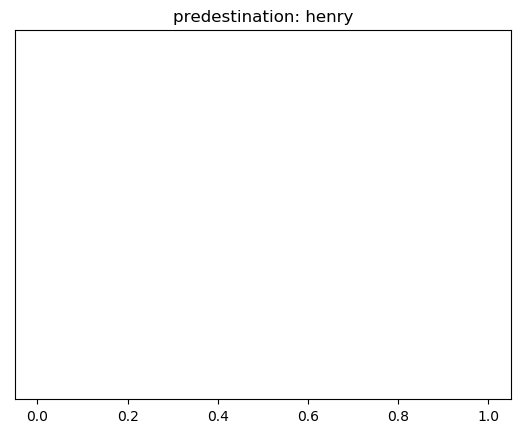

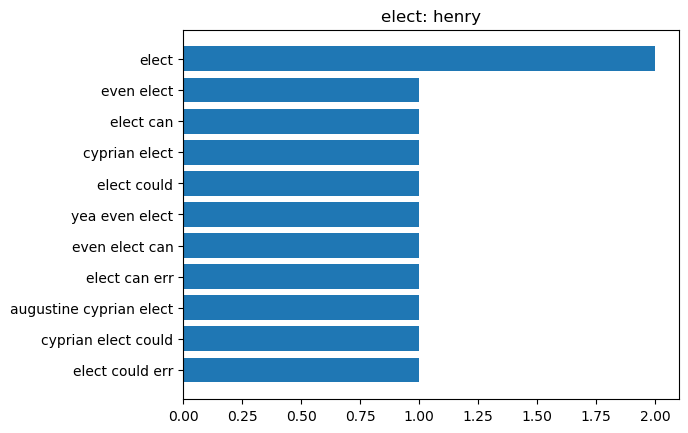

starting: edward
loading gzipped texts...
vectorizing...
extracting top terms...


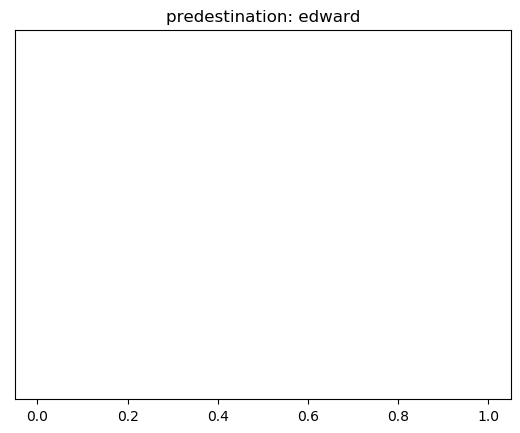

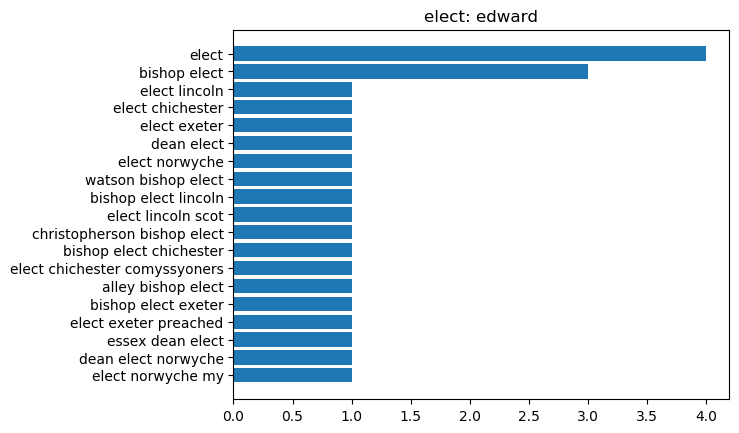

starting: mary
loading gzipped texts...
vectorizing...
extracting top terms...


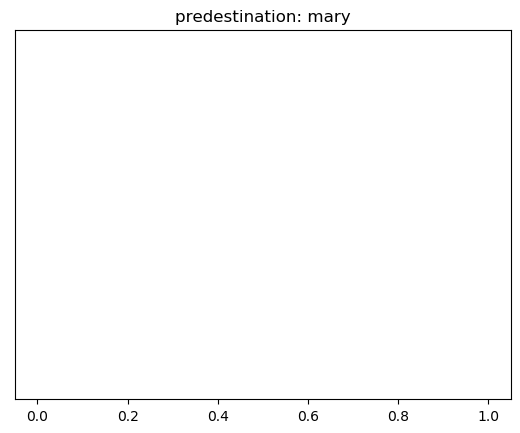

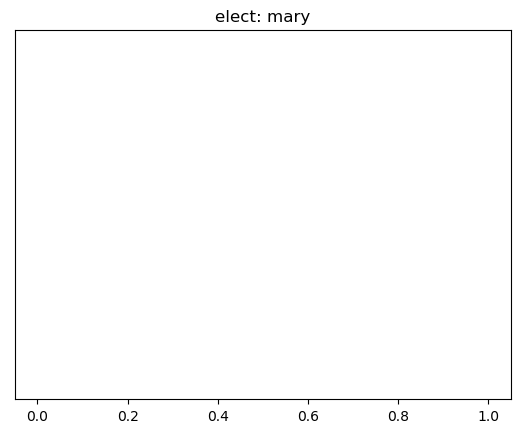

starting: elizabeth
loading gzipped texts...
vectorizing...
extracting top terms...


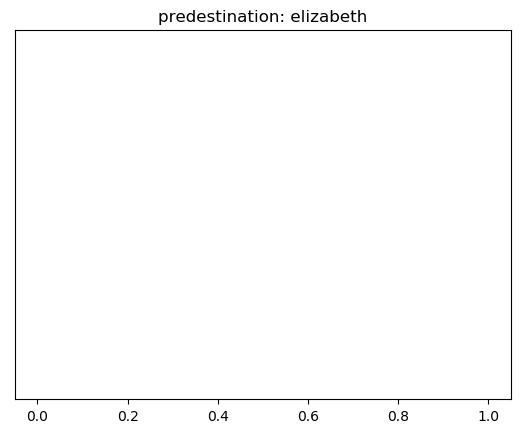

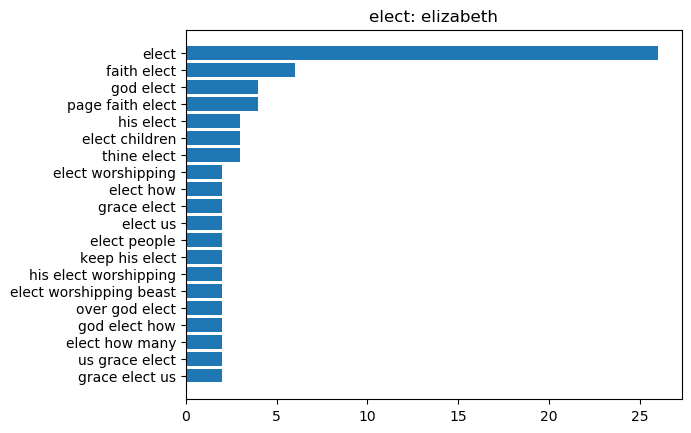

starting: james
loading gzipped texts...
vectorizing...
extracting top terms...


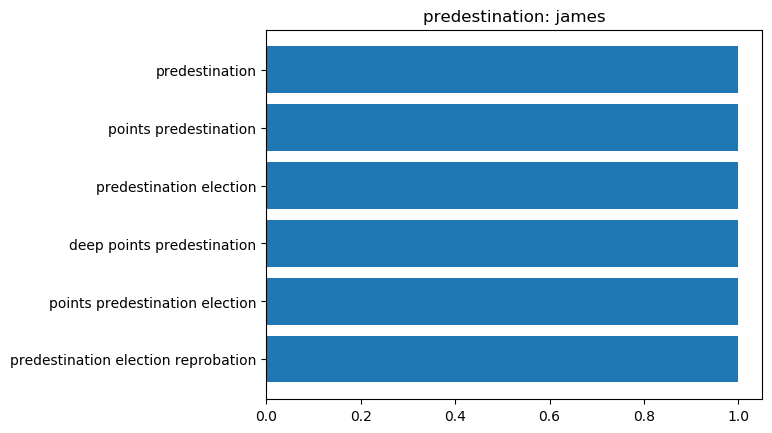

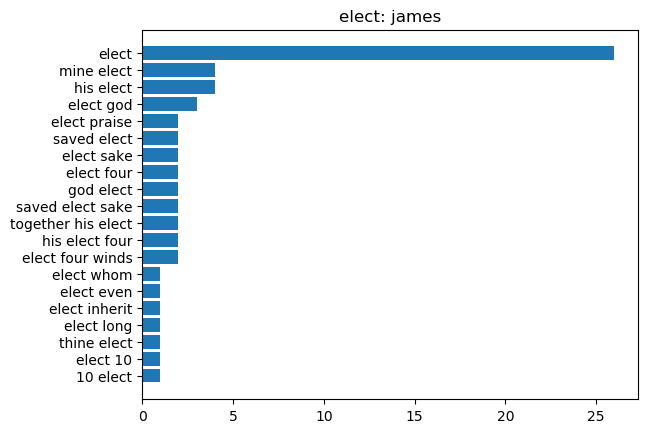

starting: charles
loading gzipped texts...
vectorizing...
extracting top terms...


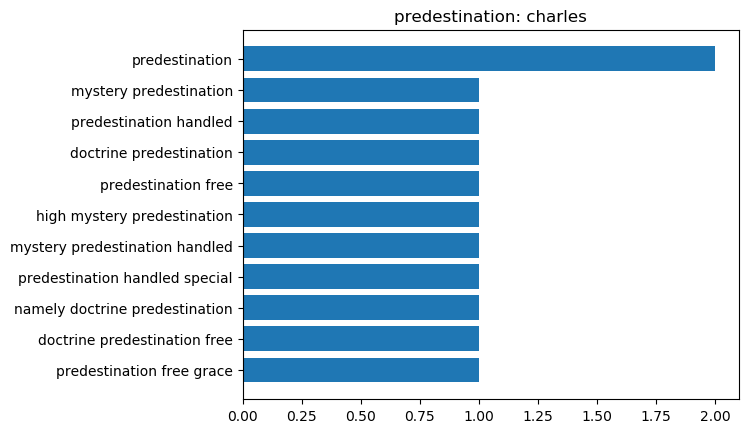

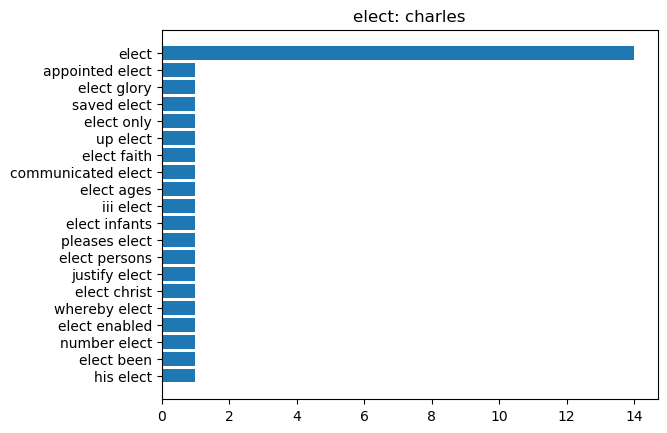

In [30]:
ktd=dict()

input_data = ["../vtexts/varded(50%) - Changes Unmarked/henry/henry.gz",
              "../vtexts/varded(50%) - Changes Unmarked/edward/edward.gz",
              "../vtexts/varded(50%) - Changes Unmarked/mary/mary.gz",
              "../vtexts/varded(50%) - Changes Unmarked/elizabeth/elizabeth.gz",
              "../vtexts/varded(50%) - Changes Unmarked/james/james.gz",
              "../vtexts/varded(50%) - Changes Unmarked/charles/charles.gz"]

for fp in input_data:
    
    # re-establisher vectorizer
    vectorizer = CountVectorizer(
        input='content',
        lowercase=True,
        ngram_range=(1,3),
        strip_accents=None,
        stop_words=stopWords)
    
    model_name = os.path.basename(fp).split(".")[0]
    print("starting: {0}".format(model_name))

    print("loading gzipped texts...")
    raw_text = gzip.open(fp,'rt').read()
    
    # vectorize model
    print("vectorizing...")
    dtm = vectorizer.fit_transform([raw_text])

    print("extracting top terms...")
    ktd = extract_top_ngrams(["predestination","elect"],dtm)
    plot_top_ngrams(ktd,model_name)
    
    # free memory
    del vectorizer, dtm
    gc.collect()